<a href="https://colab.research.google.com/github/haniyturana/Data-Science-Project/blob/main/streaming_service_customer_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
##Data Simulation
```



In [37]:
import numpy as np
import pandas as pd

# Data Generation
np.random.seed(123)
n = 2000

CustomerID = [f"M{str(i).zfill(4)}" for i in range(1, n+1)]
JoinDate = pd.to_datetime(np.random.choice(pd.date_range('2024-01-01', '2024-12-31'), size=n))
ActiveMonths = np.random.randint(1, 13, size=n)

# CancelDate: 30% chance of cancellation
CancelDate = pd.Series([jd + pd.DateOffset(months=am) if np.random.rand() < 0.3 else pd.NaT
                        for jd, am in zip(JoinDate, ActiveMonths)])

Region = np.random.choice(["Kuala Lumpur", "Penang", "East Malaysia", "Johor"], size=n)
SubscriptionType = np.random.choice(["Basic", "Standard", "Premium"], size=n, p=[0.4, 0.35, 0.25])
MonthlyFee = np.where(SubscriptionType == "Basic", 10,
                      np.where(SubscriptionType == "Standard", 20, 30))
TotalStreams = np.round(np.random.normal(150, 60, size=n)).astype(int)
DeviceType = np.random.choice(["Handphone", "Smart TV", "Laptop", "Ipad"], size=n)
PaymentMethod = np.random.choice(["Credit Card", "E Wallet", "Online Banking"], size=n)

# Create DataFrame
stream_data = pd.DataFrame({
    "CustomerID": CustomerID,
    "JoinDate": JoinDate,
    "CancelDate": CancelDate,
    "Region": Region,
    "SubscriptionType": SubscriptionType,
    "MonthlyFee": MonthlyFee,
    "ActiveMonths": ActiveMonths,
    "TotalStreams": TotalStreams,
    "DeviceType": DeviceType,
    "PaymentMethod": PaymentMethod
})

# Revenue calculation
stream_data["Revenue"] = stream_data["MonthlyFee"] * stream_data["ActiveMonths"]

In [38]:
from IPython.display import display

# Export to CSV
stream_data.to_csv("stream_data_raw.csv", index=False)

# Preview first 10 rows in a nice table format
print("=== First 10 rows ===")
display(stream_data.head(10))

# Check DataFrame structure / info
print("\n=== DataFrame Info ===")
stream_data.info()



=== First 10 rows ===


,CustomerID,JoinDate,CancelDate,Region,SubscriptionType,MonthlyFee,ActiveMonths,TotalStreams,DeviceType,PaymentMethod,Revenue
0,M0001,2024-12-31,2025-06-30,East Malaysia,Standard,20,6,229,Laptop,E Wallet,120
1,M0002,2024-11-18,NaT,Penang,Standard,20,6,209,Laptop,Online Banking,120
2,M0003,2024-04-08,NaT,Johor,Basic,10,10,139,Ipad,Online Banking,100
3,M0004,2024-08-18,NaT,Kuala Lumpur,Standard,20,4,180,Ipad,Online Banking,80
4,M0005,2024-01-18,2024-03-18,East Malaysia,Standard,20,2,248,Smart TV,Online Banking,40
5,M0006,2024-03-24,2025-02-24,Penang,Premium,30,11,104,Ipad,Online Banking,330
6,M0007,2024-04-16,NaT,Penang,Basic,10,3,235,Smart TV,E Wallet,30
7,M0008,2024-05-03,2024-09-03,East Malaysia,Premium,30,4,86,Ipad,Online Banking,120
8,M0009,2024-02-27,NaT,East Malaysia,Basic,10,11,82,Ipad,E Wallet,110
9,M0010,2024-08-02,NaT,East Malaysia,Standard,20,4,161,Laptop,E Wallet,80



=== DataFrame Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        2000 non-null   object        
 1   JoinDate          2000 non-null   datetime64[ns]
 2   CancelDate        598 non-null    datetime64[ns]
 3   Region            2000 non-null   object        
 4   SubscriptionType  2000 non-null   object        
 5   MonthlyFee        2000 non-null   int64         
 6   ActiveMonths      2000 non-null   int64         
 7   TotalStreams      2000 non-null   int64         
 8   DeviceType        2000 non-null   object        
 9   PaymentMethod     2000 non-null   object        
 10  Revenue           2000 non-null   int64         
dtypes: datetime64[ns](2), int64(4), object(5)
memory usage: 172.0+ KB


#CancelDate has missing value but consider missing is the subscriber still active


In [39]:
# Identify numeric columns
num_cols = stream_data.select_dtypes(include='number').columns

# Count negative values per numeric column
neg_counts = (stream_data[num_cols] < 0).sum()

print("Negative values at numeric variables:")
print(neg_counts)

Negative values at numeric variables:
MonthlyFee       0
ActiveMonths     0
TotalStreams    14
Revenue          0
dtype: int64


In [40]:
# Convert CancelDate to datetime
stream_data['CancelDate'] = pd.to_datetime(stream_data['CancelDate'], errors='coerce')

# Convert categorical columns to category dtype
stream_data['Region'] = stream_data['Region'].astype('category')
stream_data['DeviceType'] = stream_data['DeviceType'].astype('category')
stream_data['PaymentMethod'] = stream_data['PaymentMethod'].astype('category')

# SubscriptionType as ordered categorical
stream_data['SubscriptionType'] = pd.Categorical(
    stream_data['SubscriptionType'],
    categories=['Basic', 'Standard', 'Premium'],
    ordered=True
)

#Replace negative TotalStreams with 0
stream_data.loc[stream_data['TotalStreams'] < 0, 'TotalStreams'] = 0

#Create IsActive column (True if CancelDate is NaT)
stream_data['IsActive'] = stream_data['CancelDate'].isna()

#Extract month of joining
stream_data['MonthJoined'] = stream_data['JoinDate'].dt.month

#Check structure
print(stream_data.info())
print(stream_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        2000 non-null   object        
 1   JoinDate          2000 non-null   datetime64[ns]
 2   CancelDate        598 non-null    datetime64[ns]
 3   Region            2000 non-null   category      
 4   SubscriptionType  2000 non-null   category      
 5   MonthlyFee        2000 non-null   int64         
 6   ActiveMonths      2000 non-null   int64         
 7   TotalStreams      2000 non-null   int64         
 8   DeviceType        2000 non-null   category      
 9   PaymentMethod     2000 non-null   category      
 10  Revenue           2000 non-null   int64         
 11  IsActive          2000 non-null   bool          
 12  MonthJoined       2000 non-null   int32         
dtypes: bool(1), category(4), datetime64[ns](2), int32(1), int64(4), object(1)
memo

In [41]:
# 3.1 Total Revenue
total_revenue = stream_data['Revenue'].sum()
print("Total Revenue:", total_revenue)

# 3.2 Average Revenue per customer (ARPU)
arpu = stream_data['Revenue'].mean()
print("Average Revenue per User (ARPU):", arpu)

# 3.3 Revenue by SubscriptionType
Revenue_by_Subscriptiontype = stream_data.groupby('SubscriptionType', observed=True)['Revenue'].sum().reset_index()
Revenue_by_Subscriptiontype.rename(columns={'Revenue':'TotalRevenue'}, inplace=True)
print("\nRevenue by Subscription Type:")
display(Revenue_by_Subscriptiontype)

# 3.4 Churn rate
Number_of_cancellation = stream_data['CancelDate'].notna().sum()
Total_subscribers_at_start_of_year = stream_data['JoinDate'].notna().sum()
churn_rate = (Number_of_cancellation / Total_subscribers_at_start_of_year) * 100
print("\nChurn Rate (%):", churn_rate)

# 3.5 Revenue by Region
Revenue_by_Region = stream_data.groupby('Region', observed=True)['Revenue'].sum().reset_index()
Revenue_by_Region.rename(columns={'Revenue':'TotalRevenue'}, inplace=True)
print("\nRevenue by Region:")
display(Revenue_by_Region)

# 3.6 Average Engagement
stream_data['Average_Engagement'] = stream_data['TotalStreams'] / stream_data['ActiveMonths']
Average_Engagement_All_Users = stream_data['Average_Engagement'].mean()
print("\nAverage Engagement per User:", Average_Engagement_All_Users)


# 3.7 Monthly Joined Trend
Monthly_Joined_Trend = stream_data.groupby('MonthJoined', observed=True).size().reset_index(name='Monthly_Join')
print("\nMonthly Joined Trend:")
display(Monthly_Joined_Trend)

# 3.8 Device Usage Breakdown
Device_usage_breakdown = stream_data.groupby('DeviceType', observed=True).size().reset_index(name='Count')
Device_usage_breakdown['Percentage'] = Device_usage_breakdown['Count'] / Device_usage_breakdown['Count'].sum()
Device_usage_breakdown['Percentage_label'] = (Device_usage_breakdown['Percentage'] * 100).round().astype(int).astype(str) + '%'
Device_usage_breakdown['ypos'] = Device_usage_breakdown['Percentage'].cumsum() - 0.5 * Device_usage_breakdown['Percentage']

print("\nDevice Usage Breakdown:")
display(Device_usage_breakdown)

Total Revenue: 242530
Average Revenue per User (ARPU): 121.265

Revenue by Subscription Type:


,SubscriptionType,TotalRevenue
0,Basic,52930
1,Standard,98280
2,Premium,91320



Churn Rate (%): 29.9

Revenue by Region:


,Region,TotalRevenue
0,East Malaysia,59050
1,Johor,62890
2,Kuala Lumpur,59430
3,Penang,61160



Average Engagement per User: 37.67938102453103

Monthly Joined Trend:


,MonthJoined,Monthly_Join
0,1,191
1,2,140
2,3,167
3,4,162
4,5,179
5,6,160
6,7,158
7,8,164
8,9,154
9,10,184



Device Usage Breakdown:


,DeviceType,Count,Percentage,Percentage_label,ypos
0,Handphone,466,0.2330,23%,0.11650
1,Ipad,507,0.2535,25%,0.35975
2,Laptop,499,0.2495,25%,0.61125
3,Smart TV,528,0.2640,26%,0.86800


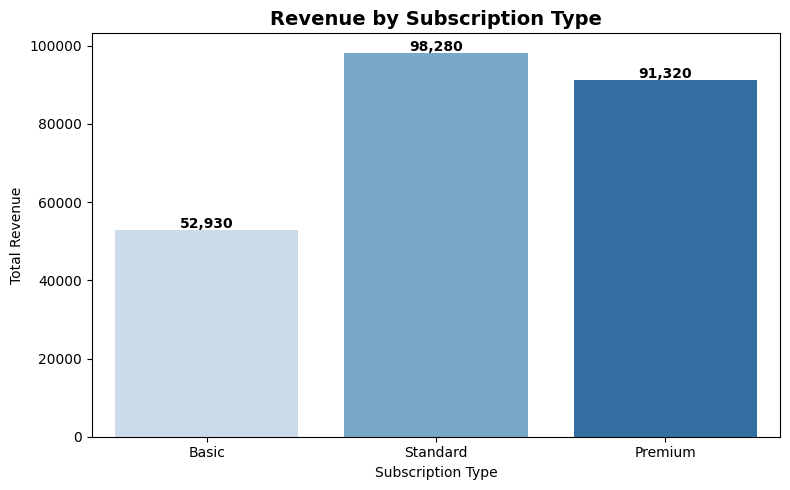

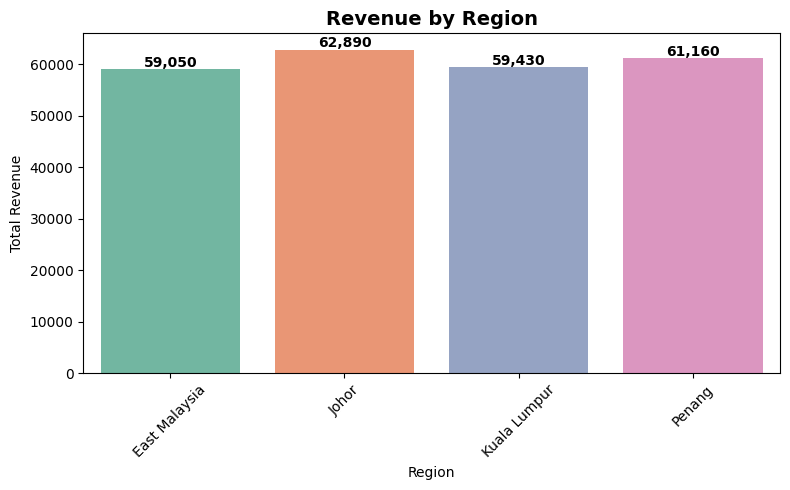

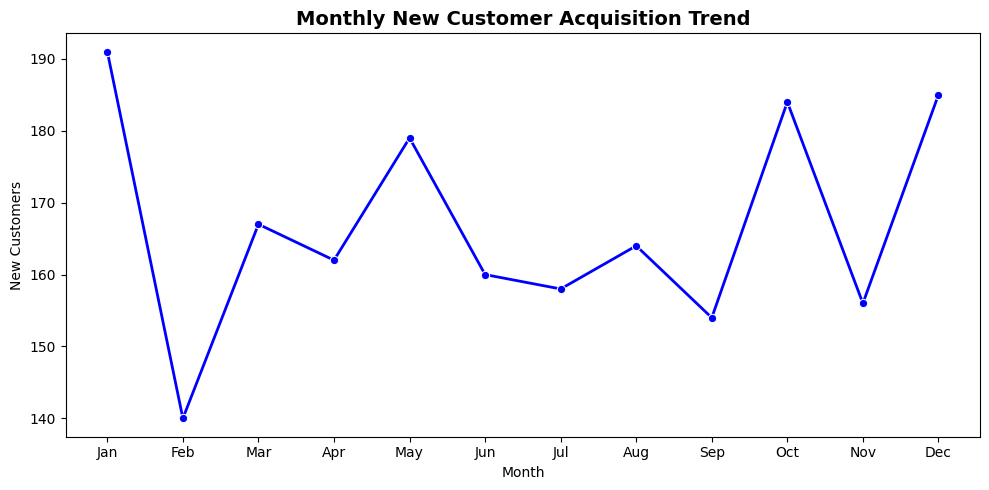

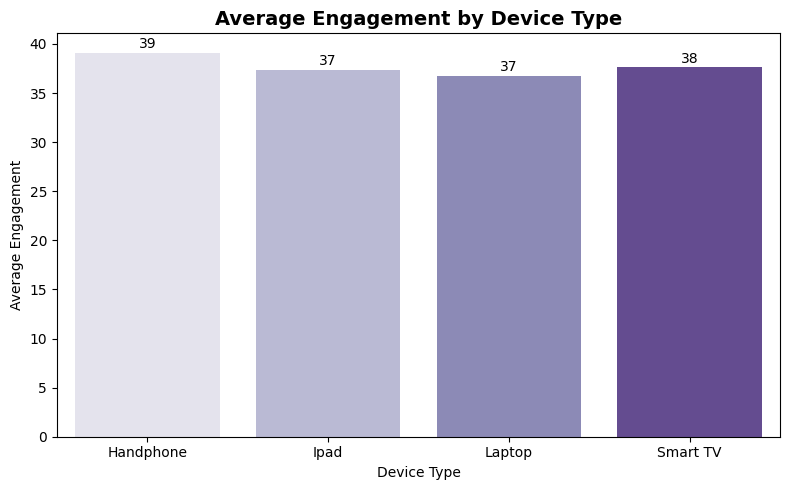

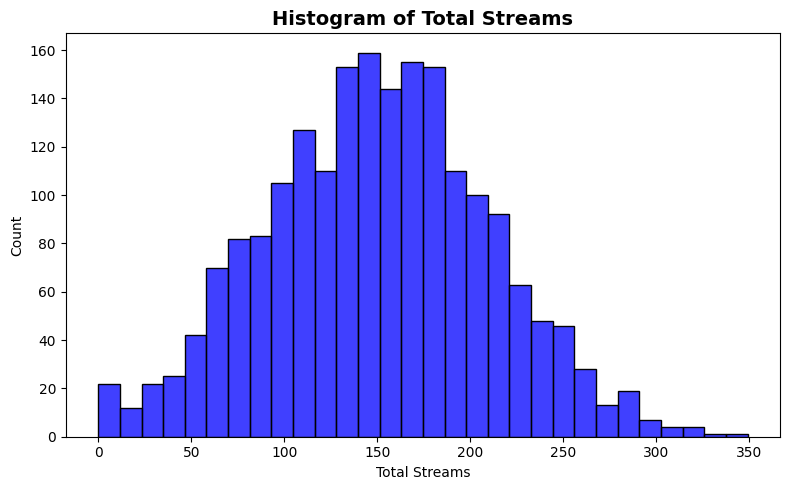

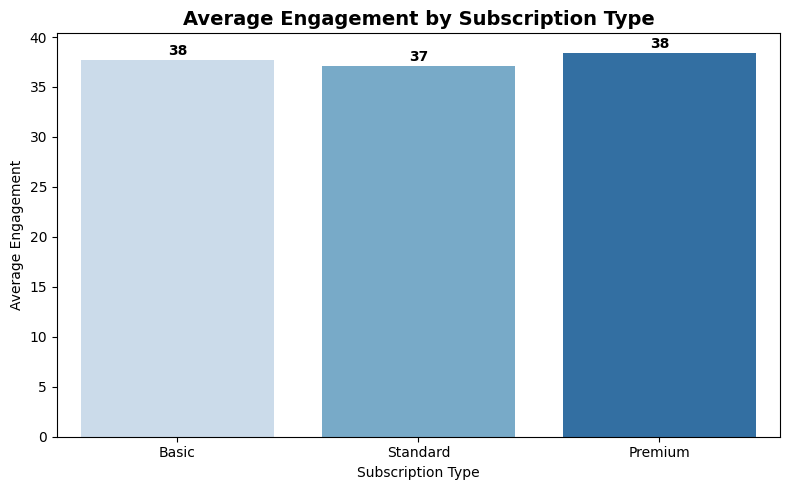

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare Engagement DataFrames
Engagement_by_Device = stream_data.groupby('DeviceType', observed=True)['Average_Engagement']\
    .mean().reset_index()

Engagement_by_Subscription = stream_data.groupby('SubscriptionType', observed=True)['Average_Engagement']\
    .mean().reset_index()

# 4.1 Revenue by Subscription Type
plt.figure(figsize=(8,5))
ax = sns.barplot(
    data=Revenue_by_Subscriptiontype.sort_values('TotalRevenue', ascending=False),
    x='SubscriptionType',
    y='TotalRevenue',
    hue='SubscriptionType',  # fix for Seaborn 0.14+ warning
    dodge=False,
    palette='Blues'
)
# Remove the legend
if ax.get_legend() is not None:
    ax.get_legend().remove()
for index, row in Revenue_by_Subscriptiontype.iterrows():
    ax.text(x=index, y=row['TotalRevenue']+500, s=f"{int(row['TotalRevenue']):,}", ha='center', fontweight='bold')
plt.title("Revenue by Subscription Type", fontsize=14, fontweight='bold')
plt.ylabel("Total Revenue")
plt.xlabel("Subscription Type")
plt.tight_layout()
plt.show()

# 4.2 Revenue by Region
plt.figure(figsize=(8,5))
ax = sns.barplot(
    data=Revenue_by_Region.sort_values('TotalRevenue', ascending=False),
    x='Region',
    y='TotalRevenue',
    hue='Region',
    dodge=False,
    palette='Set2'
)
# Remove the legend
if ax.get_legend() is not None:
    ax.get_legend().remove()
for index, row in Revenue_by_Region.iterrows():
    ax.text(x=index, y=row['TotalRevenue']+500, s=f"{int(row['TotalRevenue']):,}", ha='center', fontweight='bold')
plt.title("Revenue by Region", fontsize=14, fontweight='bold')
plt.ylabel("Total Revenue")
plt.xlabel("Region")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 4.3 Monthly Join Trend
plt.figure(figsize=(10,5))
sns.lineplot(
    data=Monthly_Joined_Trend,
    x='MonthJoined',
    y='Monthly_Join',
    marker='o',
    color='blue',
    linewidth=2
)
plt.xticks(ticks=range(1,13), labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.title("Monthly New Customer Acquisition Trend", fontsize=14, fontweight='bold')
plt.ylabel("New Customers")
plt.xlabel("Month")
plt.tight_layout()
plt.show()

# 4.4 Average Engagement by Device Type
plt.figure(figsize=(8,5))
ax = sns.barplot(
    data=Engagement_by_Device.sort_values('Average_Engagement', ascending=False),
    x='DeviceType',
    y='Average_Engagement',
    hue='DeviceType',
    dodge=False,
    palette='Purples'
)
# Remove the legend
if ax.get_legend() is not None:
    ax.get_legend().remove()
for index, row in Engagement_by_Device.iterrows():
    ax.text(x=index, y=row['Average_Engagement']+0.5, s=f"{row['Average_Engagement']:.0f}", ha='center')
plt.title("Average Engagement by Device Type", fontsize=14, fontweight='bold')
plt.ylabel("Average Engagement")
plt.xlabel("Device Type")
plt.tight_layout()
plt.show()


# 4.5 Total Streams Distribution
plt.figure(figsize=(8,5))
sns.histplot(stream_data['TotalStreams'], bins=30, kde=False, color='blue')
plt.title("Histogram of Total Streams", fontsize=14, fontweight='bold')
plt.xlabel("Total Streams")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 4.6 Average Engagement by Subscription Type
plt.figure(figsize=(8,5))
ax = sns.barplot(
    data=Engagement_by_Subscription.sort_values('Average_Engagement', ascending=False),
    x='SubscriptionType',
    y='Average_Engagement',
    hue='SubscriptionType',
    dodge=False,
    palette='Blues'
)
# Remove the legend
if ax.get_legend() is not None:
    ax.get_legend().remove()

for index, row in Engagement_by_Subscription.iterrows():
    ax.text(x=index, y=row['Average_Engagement']+0.5, s=f"{row['Average_Engagement']:.0f}", ha='center', fontweight='bold')

plt.title("Average Engagement by Subscription Type", fontsize=14, fontweight='bold')
plt.ylabel("Average Engagement")
plt.xlabel("Subscription Type")
plt.tight_layout()
plt.show()

## Calculate Customer Lifetime Value


In [43]:
#Compute CLTV for each CustID
stream_data['CLTV'] = stream_data['Revenue']

print("DataFrame after adding CLTV column:")
print(stream_data[['CustomerID', 'MonthlyFee', 'ActiveMonths', 'Revenue', 'CLTV']].head())

DataFrame after adding CLTV column:
  CustomerID  MonthlyFee  ActiveMonths  Revenue  CLTV
0      M0001          20             6      120   120
1      M0002          20             6      120   120
2      M0003          10            10      100   100
3      M0004          20             4       80    80
4      M0005          20             2       40    40


In [44]:
#Compute CLTV by Subscription Type
cltv_by_subscription_type = stream_data.groupby('SubscriptionType', observed=True)['CLTV'].mean().reset_index()
cltv_by_subscription_type.rename(columns={'CLTV': 'AverageCLTV'}, inplace=True)

print("Average CLTV by Subscription Type:")
print(cltv_by_subscription_type)

Average CLTV by Subscription Type:
  SubscriptionType  AverageCLTV
0            Basic    66.830808
1         Standard   133.170732
2          Premium   194.297872


In [45]:
#Analyze CLTV by Region
cltv_by_region = stream_data.groupby('Region', observed=True)['CLTV'].mean().reset_index()
cltv_by_region.rename(columns={'CLTV': 'AverageCLTV'}, inplace=True)

print("Average CLTV by Region:")
print(cltv_by_region)

Average CLTV by Region:
          Region  AverageCLTV
0  East Malaysia   121.004098
1          Johor   123.799213
2   Kuala Lumpur   119.337349
3         Penang   120.869565


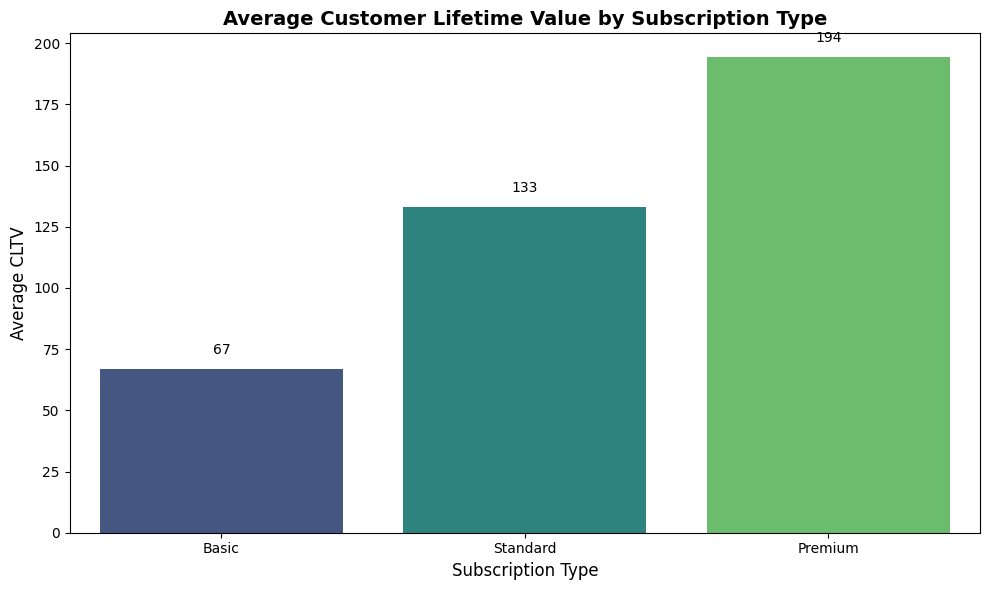

In [48]:
#graph CLTV by subs type
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=cltv_by_subscription_type.sort_values('AverageCLTV', ascending=False),
    x='SubscriptionType',
    y='AverageCLTV',
    hue='SubscriptionType', # fix for Seaborn 0.14+ warning
    palette='viridis'
)

# Remove the legend
if ax.get_legend() is not None:
    ax.get_legend().remove()

for index, row in cltv_by_subscription_type.iterrows():
    ax.text(index, row['AverageCLTV'] + 5, f"{row['AverageCLTV']:.0f}", color='black', ha="center", va='bottom', fontsize=10)

plt.title('Average Customer Lifetime Value by Subscription Type', fontsize=14, fontweight='bold')
plt.xlabel('Subscription Type', fontsize=12)
plt.ylabel('Average CLTV', fontsize=12)
plt.tight_layout()
plt.show()

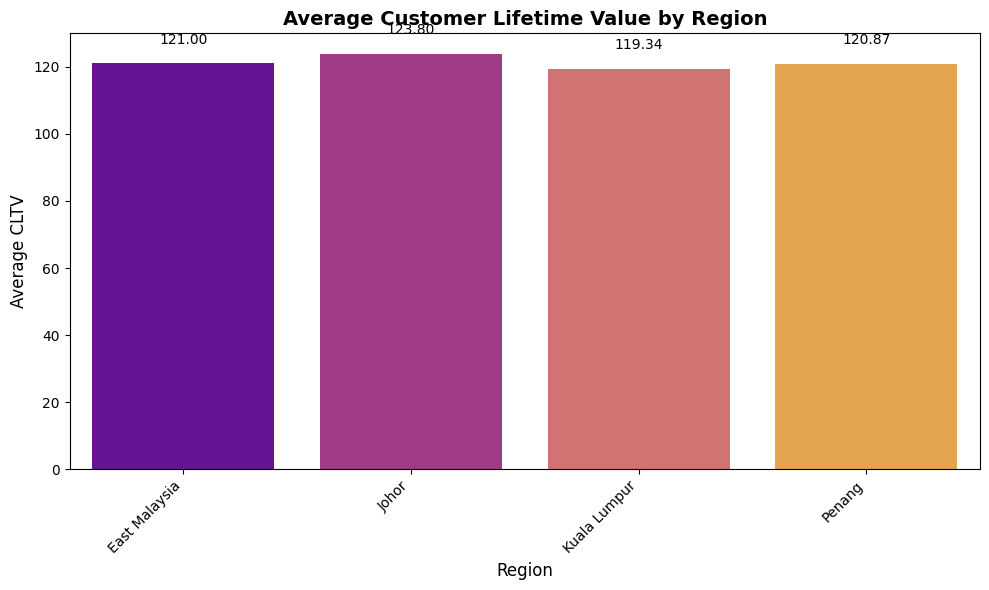

In [47]:
#graph cltv by region

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=cltv_by_region.sort_values('AverageCLTV', ascending=False),
    x='Region',
    y='AverageCLTV',
    hue='Region',
    palette='plasma'
)

# Remove the legend
if ax.get_legend() is not None:
    ax.get_legend().remove()

for index, row in cltv_by_region.iterrows():
    ax.text(index, row['AverageCLTV'] + 5, f"{row['AverageCLTV']:.0f}", color='black', ha="center", va='bottom', fontsize=10)

plt.title('Average Customer Lifetime Value by Region', fontsize=14, fontweight='bold')
plt.xlabel('Region', fontsize=12)
plt.ylabel('Average CLTV', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Summary:

### Revenue Snapshot
1.  Highest Revenue Region: East Malaysia
2.  Top Subscription Plan: Premium
3.  Premium Charges the highest price ($30/month)
4.  Laptop and Mobile has the highest engagement rate.

### Overall Churn Rate is 29%
1.  Content not suited to audience in Malaysia
2.  Confusing platform navigation
3.  Long term subscription is pricey
4.  Cheaper competitors

### Customer Lifetime Value (CLTV)
1.  Premium subscriptions for highest CLTV and EM as the region with highest average CLTV.



### Insights or Next Steps
*   **Targeted Premium Upgrade Campaigns:** Make content suited to target audience in Malaysia regions: Johor. Penang, East Malaysia and Kuala Lumpur

*   **UI/UX:** Optimize platform usability & navigation for better user experience

*   **Price** Offer lower subscription prices when users want to unsubscribe

*   **Competitor Analysis** Assess competitors’ offerings & pricings (Netflix & Disney+) then reprice according to market


